In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# from tensorboardX import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [208]:
fpath = "../../data/DNN_data/v1/"

sig_with_artifact = np.load(fpath + "data_signal_with_sine_regular_pattern" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


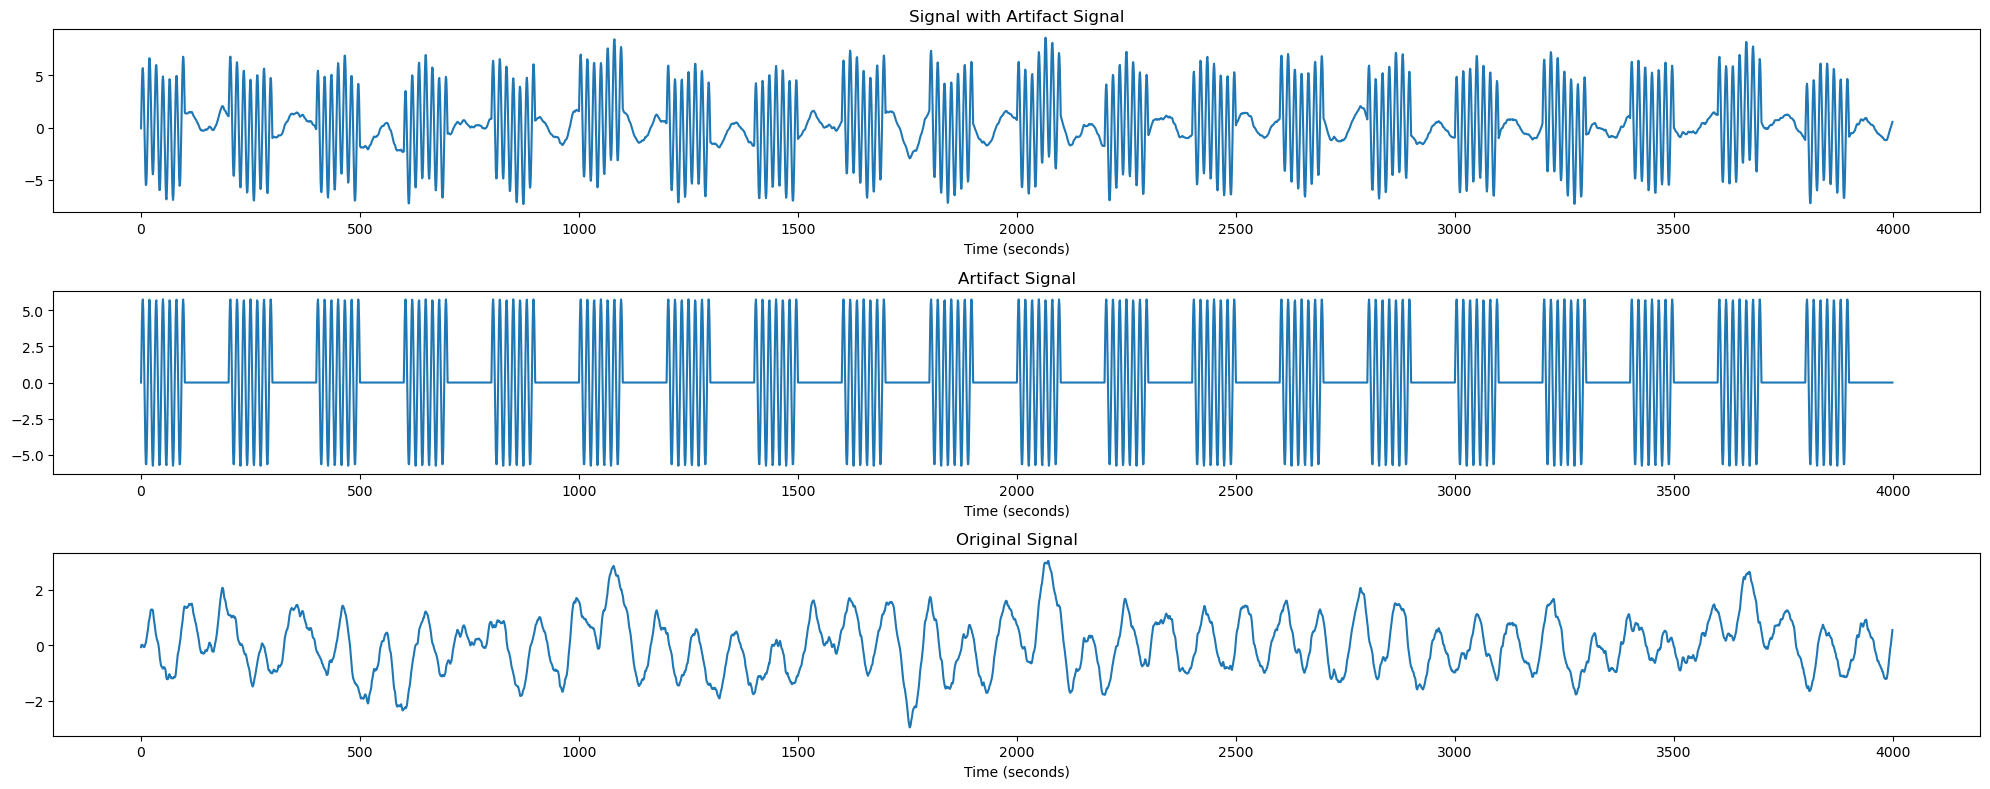

In [209]:
plt.figure(figsize=(20,8))

plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

In [210]:
sig_with_artifact = sig_with_artifact.transpose()
sig = sig.transpose()

print(sig_with_artifact.shape)
print(sig.shape)

(4000, 1000)
(4000, 1000)


(1000, 4000)
(1000, 4000)


(-3.0, 3.0)

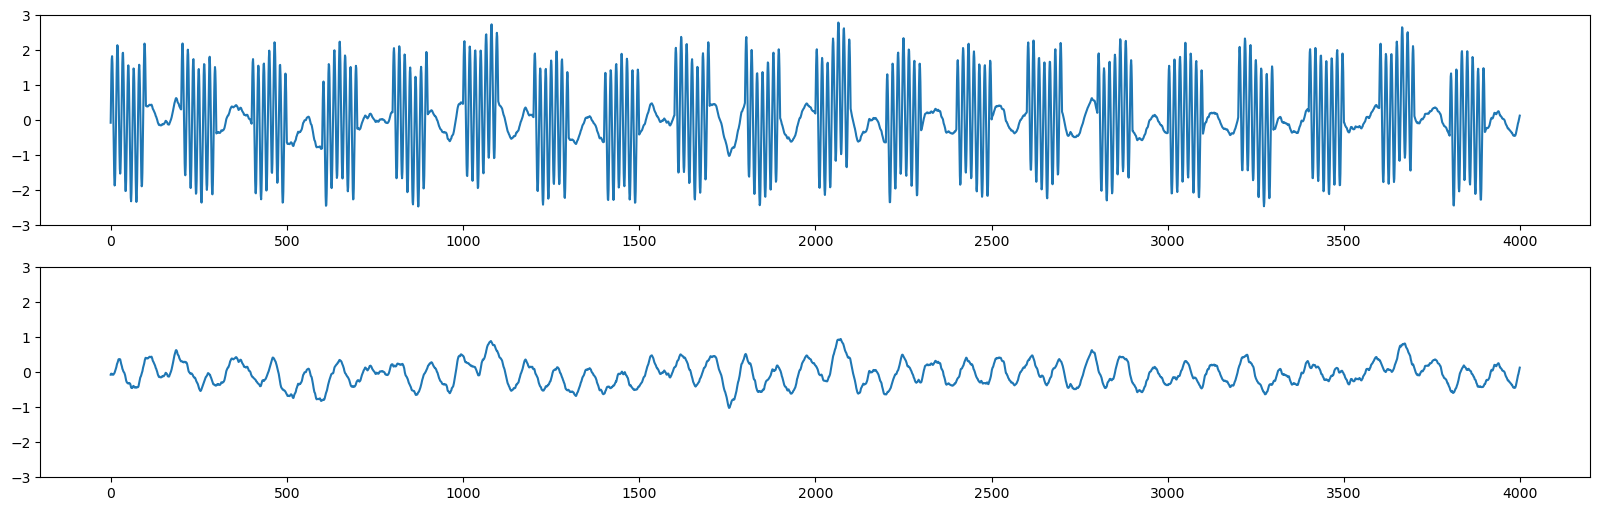

In [211]:
# StandardScaler를 이용하여 정규화
scaler = StandardScaler()
X = scaler.fit_transform(sig_with_artifact)
# y = scaler.fit_transform(sig)
y = (sig-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.transpose()
y = y.transpose()

print(X.shape)
print(y.shape)

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(X[0])
plt.ylim([-3, 3])
plt.subplot(2, 1, 2)
plt.plot(y[0])
plt.ylim([-3, 3])

In [212]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

X_train = X_train.reshape(X_train.shape[0], 1, 4000)
X_test = X_test.reshape(X_test.shape[0], 1, 4000)

print("<unsqueezed>")
print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<unsqueezed>
-----------------------------
X_train shape: (800, 1, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 1, 4000)
y_test shape: (200, 4000)
-----------------------------


In [213]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # hidden layer의 뉴런 개수

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc2 = nn.Linear(128, num_classes) # 출력층

        self.gelu = nn.GELU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)
        out = self.fc_1(out)
        out = self.gelu(out)
        out = self.fc(out)
        return out

In [214]:
# 인코더 네트워크 생성

class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
        print(x.shape, h_0.shape, c_0.shape)

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        out = self.lstm(output)
        h_ = self.LeakyReLU(out)
        mean = self.mean(h_)
        log_var = self.var(h_)                           
        return mean, log_var # 인코더 네트워크에서 평균과 분산을 반환

In [215]:
# 디코더 네트워크

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers=2):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_dim
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers=2)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = x.reshape(x.size(0), x.size(1), 1)
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        out = self.lstm(output)
        h = self.LeakyReLU(out)        
        # x_hat = torch.sigmoid(self.output(h)) # 디코더 결과는 시그모이드를 통과했으므로 0~1 값을 가짐
        x_hat = self.output(h)
        return x_hat 

In [216]:
# VAE 네트워크

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var): # 평균과 표준편차를 통해 latent vector z를 샘플링
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon # z 값 구하기   
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var # 디코더 결과와 평균, 표준편차를 반환

In [217]:
# 인코더와 디코더 객체 초기화

x_dim  = 4000
hidden_dim = 400
latent_dim = 40
epochs = 5000
batch_size = 50

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [218]:
# 손실 함수 정의

def loss_function(x, x_hat, mean, log_var): # 오차 구하는 함수, KLD를 계산하고 KLD가 줄어드는 방향으로 q(z)를 업데이트
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # Loss Function을 BCE에서 MSE로 변경
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [219]:
# 모델 학습 함수 정의 2

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# import os
# import shutil
# if os.path.exists('scalar/'):
#     # 폴더가 존재하면 폴더 내의 모든 내용을 삭제
#     shutil.rmtree('scalar/')

# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model.train()
def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(batch_size, 1, x_dim)
        x = x.to(device)
        y = y.view(batch_size, 1, x_dim)
        y = y.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        MSE, KLD = loss_function(y, x_hat, mean, log_var)
        loss = MSE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {}\t Loss: {:.6f}'.format(
        #         epoch, loss.item() / len(y)))
    if epoch == 0:
        print(f"Epoch: [{epoch}/{epochs}]\t\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')
    elif epoch%10==0:        
        print(f"Epoch: [{epoch}/{epochs}]\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')

In [220]:
# 모델 평가 함수 정의

def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.view(batch_size, 1, x_dim)
            x = x.to(device)  
            y = y.view(batch_size, 1, x_dim) 
            y = y.to(device)     
            x_hat, mean, log_var = model(x)
            MSE, KLD = loss_function(y, x_hat, mean, log_var)
            loss = MSE + KLD

            # 테스트 데이터셋에 대해서도 오차를 로그에 저장
            # writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(x.size(0), 8)
            #     comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
            #     grid = torchvision.utils.make_grid(comparison.cpu()) 
            #     writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
        if epoch == 0:
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        elif epoch%10==0:        
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

In [221]:
# 모델 학습

from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
# writer.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

torch.Size([50, 1, 4000]) torch.Size([2, 50, 400]) torch.Size([2, 50, 400])


RuntimeError: input.size(-1) must be equal to input_size. Expected 4000, got 400

In [ ]:
with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)

x = x.cpu()
x_hat = x_hat.cpu()

t = np.linspace(0, 2, num=4000)           

plt.figure(figsize=(20,6))

plt.subplot(2, 1, 1)
plt.plot(t, x[0])

plt.subplot(2, 1, 2)
plt.plot(t, y[0], label='Actual')
plt.plot(t, x_hat[0], label='Predicted')
plt.legend()

In [ ]:
# 텐서보드에서 오차 확인

# %load_ext tensorboard # magic command
# %tensorboard --logdir scalar --port=6013

In [ ]:
# time domain plotting

predicted_signal = x_hat[0]
actual_signal = y[0]

t = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='orange', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

In [ ]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=1, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")